# Water level data processing

## Raw Water Level Data Processing and Visualization

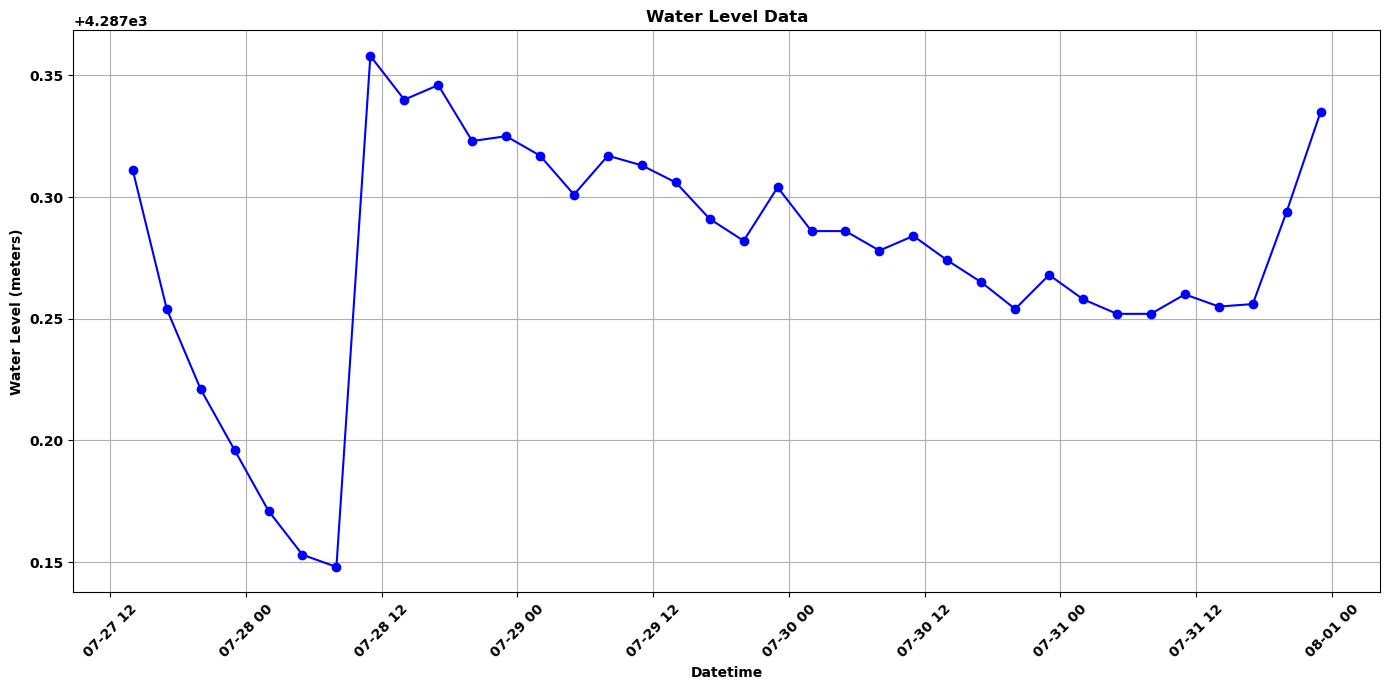

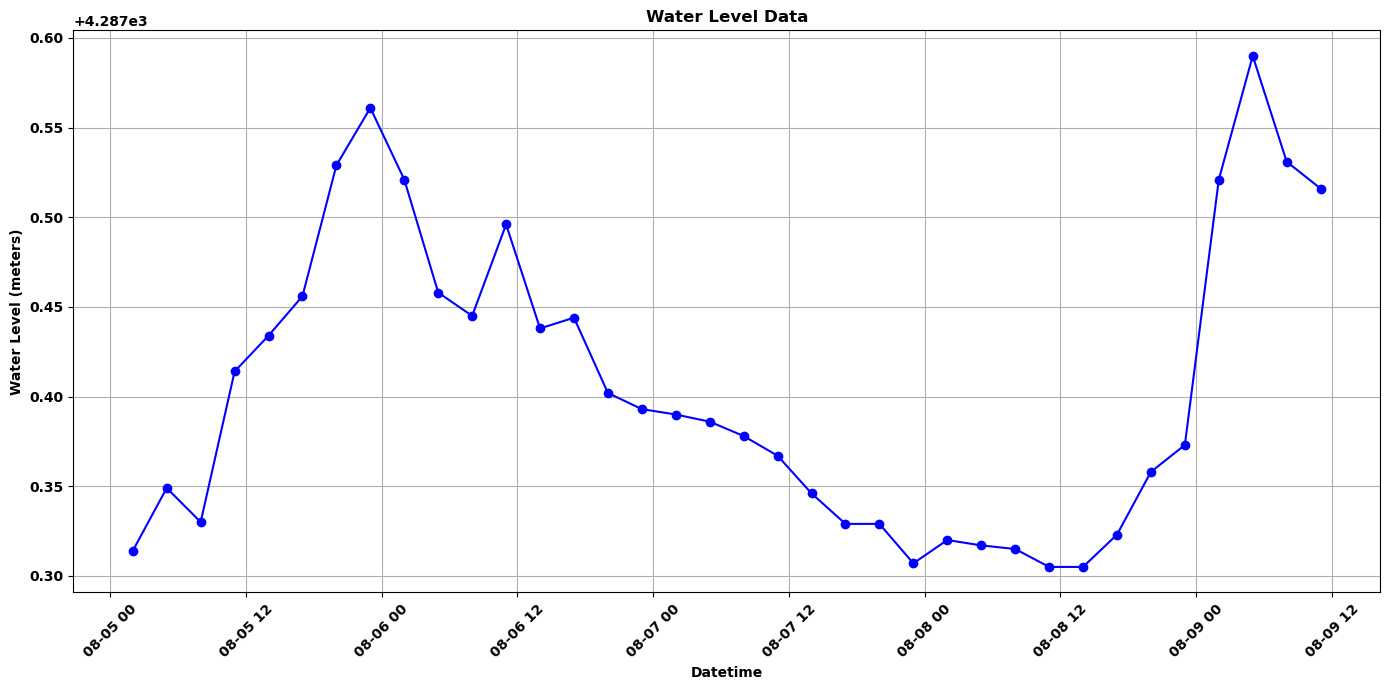

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime
import os
import glob

# Function to parse datetime strings
def parse_datetime(dt_str):
    try:
        dt_str = re.sub(r'下午', 'PM', dt_str)
        dt_str = re.sub(r'上午', 'AM', dt_str)
        return datetime.strptime(dt_str, '%m/%d/%y %p%I时%M分%S秒')
    except ValueError:
        return pd.NaT  # Return NaT for parsing failures

# Directory containing the CSV files
data_dir = './data/'
output_dir = './processing/'
os.makedirs(output_dir, exist_ok=True)

# Get list of all CSV files in the data directory
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

# Process each CSV file
for file_path in csv_files:
    data = pd.read_csv(file_path, skiprows=1)  # Skip the first header row

    # Rename columns for easier access
    data.columns = ['Index', 'Datetime', 'Absolute Pressure', 'Temperature', 'Water Level', 'Coupler Disconnected', 'Coupler Connected', 'Host Connected', 'Stopped', 'End of File']

    # Select required columns
    data = data[['Datetime', 'Absolute Pressure', 'Temperature', 'Water Level']]

    # Convert datetime to proper datetime format
    data['Datetime'] = data['Datetime'].apply(parse_datetime)

    # Drop rows with unparseable datetime
    data.dropna(subset=['Datetime'], inplace=True)

    # Convert water level to numeric, force errors to NaN
    data['Water Level'] = pd.to_numeric(data['Water Level'], errors='coerce')

    # Mark water level outside 4287-4288 as NaN
    data['Water Level'] = data.apply(lambda row: np.nan if row['Water Level'] < 4287 or row['Water Level'] > 4288 else row['Water Level'], axis=1)

    # Drop rows with NaN in water level
    data.dropna(subset=['Water Level'], inplace=True)

    # Get the original file name without the directory and extension
    base_name = os.path.basename(file_path)
    file_name = os.path.splitext(base_name)[0]

    # Generate output filenames
    output_file = os.path.join(output_dir, f'{file_name}_Processed.csv')
    plot_file = os.path.join(output_dir, f'{file_name}_Water_Level_Data.png')

    # Output processed data
    data.to_csv(output_file, index=False, encoding='utf-8-sig')

    # Plot water level data
    plt.figure(figsize=(14, 7))
    plt.plot(data['Datetime'], data['Water Level'], marker='o', linestyle='-', color='b')
    plt.title('Water Level Data')
    plt.xlabel('Datetime')
    plt.ylabel('Water Level (meters)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save plot as image
    plt.savefig(plot_file)

    # Show plot
    plt.show()


## Batch Processing of Water Level Data and Flow Rate Calculation

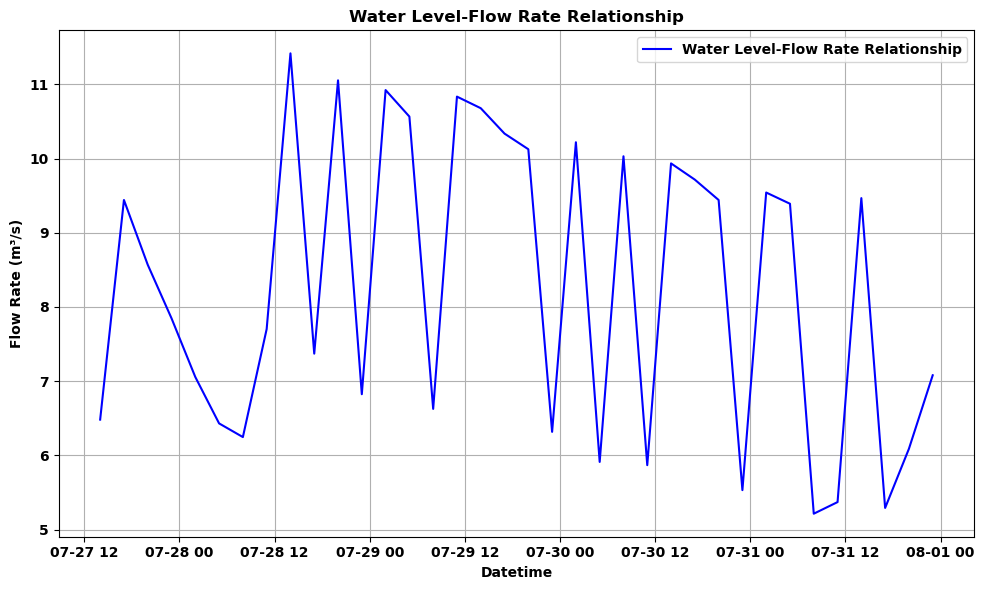

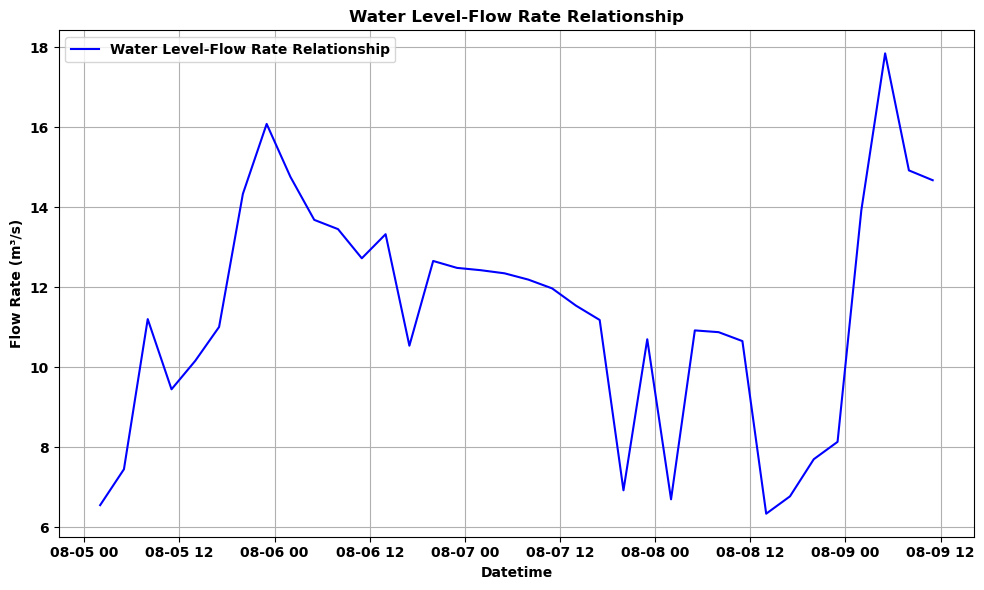

Water level-flow rate calculation complete. Results saved.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import os
import glob

# Fitting parameters (replace with actual fitting results)
a_rise = 10.0000
b_rise = 0.0259
c_rise = 4276.8150

a_fall = 0.0020
b_fall = 0.0018
c_fall = 4287.0587

# Define fitting functions
def rise_fit_func(x, a, b, c):
    return a * np.power(x, b) + c

def fall_fit_func(x, a, b, c):
    return a * x**2 + b * x + c

# Inverse functions to calculate flow rate using the fitting equations
def inverse_rise_fit(y, a, b, c):
    results = []
    for val in y:
        try:
            if not np.isnan(val):
                if val < rise_fit_func(0.1, a, b, c) or val > rise_fit_func(1000, a, b, c):
                    raise ValueError(f"Value {val} out of bounds for rise fit.")
                result = brentq(lambda x: rise_fit_func(x, a, b, c) - val, 0.1, 1000)
                results.append(result)
            else:
                results.append(np.nan)
        except ValueError as e:
            print(f"Error for value {val} in rise fit: {e}")
            results.append(np.nan)
    return np.array(results)

def inverse_fall_fit(y, a, b, c):
    results = []
    for val in y:
        try:
            if not np.isnan(val):
                if val < fall_fit_func(0.1, a, b, c) or val > fall_fit_func(1000, a, b, c):
                    raise ValueError(f"Value {val} out of bounds for fall fit.")
                result = brentq(lambda x: fall_fit_func(x, a, b, c) - val, 0.1, 1000)
                results.append(result)
            else:
                results.append(np.nan)
        except ValueError as e:
            print(f"Error for value {val} in fall fit: {e}")
            results.append(np.nan)
    return np.array(results)

# Directory containing the CSV files
input_dir = './processing/'
output_dir = './result/'
os.makedirs(output_dir, exist_ok=True)

# Get list of all CSV files in the input directory
csv_files = glob.glob(os.path.join(input_dir, '*.csv'))

# Process each CSV file
for file_path in csv_files:
    df_water_level = pd.read_csv(file_path, parse_dates=['Datetime'])
    df_water_level.set_index('Datetime', inplace=True)

    # Determine which fitting function to use based on water level trend
    rise_indices = df_water_level['Water Level'].diff().fillna(0) >= 0
    fall_indices = ~rise_indices

    df_water_level['Flow Rate (m³/s)'] = np.nan
    df_water_level.loc[rise_indices, 'Flow Rate (m³/s)'] = inverse_rise_fit(df_water_level.loc[rise_indices, 'Water Level'], a_rise, b_rise, c_rise)
    df_water_level.loc[fall_indices, 'Flow Rate (m³/s)'] = inverse_fall_fit(df_water_level.loc[fall_indices, 'Water Level'], a_fall, b_fall, c_fall)

    # Get the original file name without the directory and extension
    base_name = os.path.basename(file_path)
    file_name = os.path.splitext(base_name)[0]

    # Generate output filenames
    output_file = os.path.join(output_dir, f'{file_name}_Calculated_Flow_Rate.csv')
    plot_file = os.path.join(output_dir, f'{file_name}_Water_Level_Data.png')

    # Output processed data
    df_water_level.to_csv(output_file, encoding='utf-8-sig')

    # Plot water level-flow rate relationship
    plt.figure(figsize=(10, 6))
    plt.plot(df_water_level.index, df_water_level['Flow Rate (m³/s)'], label='Water Level-Flow Rate Relationship', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Flow Rate (m³/s)')
    plt.title('Water Level-Flow Rate Relationship')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot as image
    plt.savefig(plot_file)

    # Show plot
    plt.show()

print("Water level-flow rate calculation complete. Results saved.")
